In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ReduceLROnPlateau
import os

C:\Users\athar\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\athar\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encoun

In [2]:
epochs = 50

from mtg_jamendo_dataset.scripts import commons

input_file = 'C:/Projects/Music_Tagging/mtg_jamendo_dataset/data/autotagging_moodtheme.tsv'
tracks, tags, extra = commons.read_file(input_file)

paths = []
tags = []
for song_id, song_data in tracks.items():
    paths.append(song_data['path'])
    tags.append(song_data['mood/theme'])

df = pd.DataFrame({'paths': paths, 'tags': tags})

df['tags'] = df['tags'].astype(str)

# Remove curly braces, split the tags, and strip whitespaces and quotes
df['tags'] = df['tags'].str.replace('{', '').str.replace('}', '').str.split(',')
df['tags'] = df['tags'].apply(lambda tags: [tag.strip().strip("'").strip('"').strip() for tag in tags])

# Get unique tags
unique_tags = set()
for tags in df['tags']:
    unique_tags.update(tags)

# Convert the set of unique tags to a list
unique_classes = list(unique_tags)


Reading: 18486 tracks, 4506 albums, 1533 artists


C:\Users\athar\AppData\Local\Temp\ipykernel_20864\3200413022.py:19: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['tags'] = df['tags'].str.replace('{', '').str.replace('}', '').str.split(',')


In [3]:
def data_table(tracks):
    paths = []
    tags = []
    for song_id, song_data in tracks.items():
        paths.append(song_data['path'])
        tags.append(song_data['mood/theme'])

    df = pd.DataFrame({'paths': paths, 'tags': tags})
    df['tags'] = df['tags'].astype(str)
    df['tags'] = df['tags'].str.replace('{', '').str.replace('}', '')
    df['paths'] = df['paths'].str.replace('/', '_')
    df['paths'] = 'C:/Projects/Music_Tagging/large_mel_spec/' + df['paths']
    df['paths'] = df['paths'].str.replace('.mp3', '.low.npy')

    return df

df = data_table(tracks)
df.head(10)

C:\Users\athar\AppData\Local\Temp\ipykernel_20864\3256525035.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['tags'] = df['tags'].str.replace('{', '').str.replace('}', '')
C:\Users\athar\AppData\Local\Temp\ipykernel_20864\3256525035.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['paths'] = df['paths'].str.replace('.mp3', '.low.npy')


,paths,tags
0,C:/Projects/Music_Tagging/large_mel_spec/48_94...,'background'
1,C:/Projects/Music_Tagging/large_mel_spec/50_95...,'background'
2,C:/Projects/Music_Tagging/large_mel_spec/51_95...,'background'
3,C:/Projects/Music_Tagging/large_mel_spec/65_21...,'film'
4,C:/Projects/Music_Tagging/large_mel_spec/63_22...,'melancholic'
5,C:/Projects/Music_Tagging/large_mel_spec/46_33...,"'melodic', 'calm'"
6,C:/Projects/Music_Tagging/large_mel_spec/47_33...,"'melodic', 'calm'"
7,C:/Projects/Music_Tagging/large_mel_spec/48_33...,"'melodic', 'calm'"
8,C:/Projects/Music_Tagging/large_mel_spec/49_33...,"'melodic', 'calm'"
9,C:/Projects/Music_Tagging/large_mel_spec/50_33...,"'melodic', 'calm'"


In [4]:
df['tags'] = df['tags'].str.replace("'", "").str.split(', ')

mlb = MultiLabelBinarizer()

# Transform the 'tags' column into binary columns
binary_labels = mlb.fit_transform(df['tags'])

# Create a new DataFrame with binary labels
df_labels = pd.DataFrame(binary_labels, columns=mlb.classes_)

# Concatenate the new labels DataFrame with the original DataFrame
df = pd.concat([df, df_labels], axis=1)

# Drop the original 'tags' column if you no longer need it
df.drop('tags', axis=1, inplace=True)

df.head()

,paths,action,adventure,advertising,ambiental,background,ballad,calm,children,christmas,...,slow,soft,soundscape,space,sport,summer,trailer,travel,upbeat,uplifting
0,C:/Projects/Music_Tagging/large_mel_spec/48_94...,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,C:/Projects/Music_Tagging/large_mel_spec/50_95...,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,C:/Projects/Music_Tagging/large_mel_spec/51_95...,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,C:/Projects/Music_Tagging/large_mel_spec/65_21...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,C:/Projects/Music_Tagging/large_mel_spec/63_22...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
from tensorflow.keras.utils import Sequence

class SpectrogramDataGenerator(Sequence):
    def __init__(self, dataframe, batch_size, mel_shape=(128, 1024, 1), spectrogram_dir='path_to_spectrograms'):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.mel_shape = mel_shape
        self.spectrogram_dir = spectrogram_dir

    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        batch_df = self.dataframe.iloc[start_idx:end_idx]
        
        X = np.zeros((len(batch_df), *self.mel_shape))
        y = batch_df.iloc[:, 1:].values  # Assuming binary class labels are in columns 1 onwards

        for i, spectrogram_path in enumerate(batch_df['paths']):
            spectrogram = np.load(os.path.join(self.spectrogram_dir, spectrogram_path))
            X[i] = spectrogram.reshape(self.mel_shape)

        return X, y

batch_size = 24
mel_shape = (128, 1024, 1)  # Modify this according to your mel spectrogram shape
spectrogram_dir = 'C:/Projects/Music_Tagging/large_mel_spec/'

train_df, val_test_df = train_test_split(df, test_size=0.3, random_state=17)  # Allocating 30% for combined validation and test sets

# Further split the validation/test set into separate validation and test sets
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=17)  # Splitting half for validation and half for test

# Create data generators for training, validation, and test sets
train_generator = SpectrogramDataGenerator(train_df, batch_size=batch_size, mel_shape=mel_shape, spectrogram_dir=spectrogram_dir)
val_generator = SpectrogramDataGenerator(val_df, batch_size=batch_size, mel_shape=mel_shape, spectrogram_dir=spectrogram_dir)
test_generator = SpectrogramDataGenerator(test_df, batch_size=batch_size, mel_shape=mel_shape, spectrogram_dir=spectrogram_dir)

In [6]:
initial_learning_rate = 0.001

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0000001)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [34]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, LSTM, Dense, Flatten, TimeDistributed, Input, Dropout
from tensorflow.keras.models import Model

def create_crnn_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    # Convolutional layers
    conv_1 = Conv2D(32, (3, 3), activation='relu')(input_layer)
    pool_1 = MaxPooling2D((2, 2))(conv_1)
    dropout_1 = Dropout(0.1)(pool_1)
    bn_1 = BatchNormalization()(dropout_1)

    conv_2 = Conv2D(64, (3, 3), activation='relu')(bn_1)
    pool_2 = MaxPooling2D((3, 3))(conv_2)
    dropout_2 = Dropout(0.1)(pool_2)
    bn_2 = BatchNormalization()(dropout_2)

    conv_3 = Conv2D(128, (3, 3), activation='relu')(bn_2)
    pool_3 = MaxPooling2D((4, 4))(conv_3)
    dropout_3 = Dropout(0.1)(pool_3)
    bn_3 = BatchNormalization()(dropout_3)

    
    # Reshape output for RNN input
    reshape = TimeDistributed(Flatten())(bn_3)

    # RNN layer
    lstm_1 = LSTM(32, return_sequences=True)(reshape)
    lstm_2 = LSTM(32, return_sequences=False)(lstm_1)
    # Fully connected layer
    dense = Dense(64, activation='relu')(lstm_2)
    output_layer = Dense(num_classes, activation='sigmoid')(dense)  # sigmoid for multi-label classification

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Define your model
input_shape = (128, 1024, 1)  # example input shape, adjust to your needs
num_classes = 59  # adjust to the number of classes
crnn_model = create_crnn_model(input_shape, num_classes)

In [8]:
# Compile the model
crnn_model.compile(optimizer=Adam(learning_rate=initial_learning_rate), loss=BinaryCrossentropy(), metrics=['binary_accuracy',tf.keras.metrics.AUC()])
crnn_model.summary()
# Train the model
crnn_model_history = crnn_model.fit(train_generator, epochs=epochs, validation_data=val_generator, callbacks=[early_stopping,reduce_lr])

# Evaluate the model
loss, accuracy, auc = crnn_model.evaluate(test_generator)
print(f'Validation loss: {loss:.4f}, Validation accuracy: {accuracy:.4f}')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 1024, 1)]    0         
                                                                 
 conv2d (Conv2D)             (None, 126, 1022, 32)     320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 511, 32)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 511, 32)       0         
                                                                 
 batch_normalization (BatchN  (None, 63, 511, 32)      128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 509, 64)       18496 

NameError: name 'base_model' is not defined

In [9]:
crnn_model.save("crnn_model.h5")

tf.keras.backend.clear_session()

In [29]:
threshold = 0.1

spectrogram_path = 'C:/Projects/Music_Tagging/large_mel_spec/48_948.low.npy'
spectrogram = np.load(spectrogram_path)  # Replace with the path to your spectrogram file
spectrogram = spectrogram.reshape(1, 128, 1024, 1)  # Add a batch dimension

predictions = crnn_model.predict(spectrogram)

class_indices = np.where(predictions[0] >= threshold)[0]  # Use a threshold to select classes

# Get the class labels corresponding to the selected indices
selected_classes = [unique_classes[i] for i in class_indices]

# Print or use the selected classes
print("Selected classes:", selected_classes)

1/1 [==============================] - 0s 18ms/step
Selected classes: ['party']


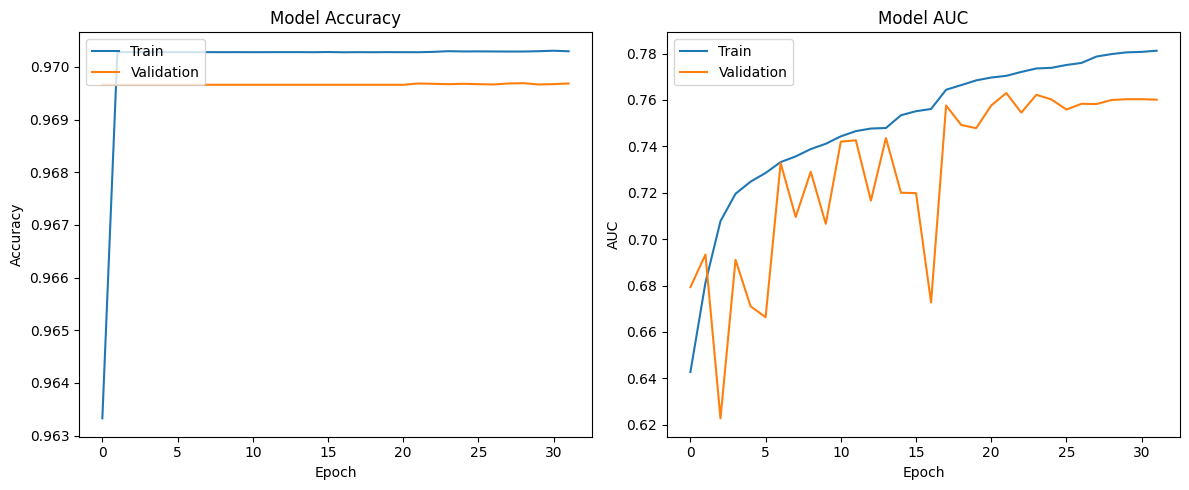

In [37]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(crnn_model_history.history['binary_accuracy'])
plt.plot(crnn_model_history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting training & validation AUC
plt.subplot(1, 2, 2)
plt.plot(crnn_model_history.history['auc'])
plt.plot(crnn_model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('model_performance.png')
plt.show()
